# Solving Higher-Order ODEs

Teng-Jui Lin

Content adapted from UW AMATH 301, Beginning Scientific Computing, in Spring 2020.

- Solving higher-order ODEs (systems of first-order ODEs)
    - Forward Euler
    - Backward Euler
- `scipy` implementation
    - Solving systems of first-order ODEs by [`scipy.integrate.solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)

## Solving higher-order ODEs (system of ODEs)
A higher-order ODE can always be written as a system of first-order ODEs. We can then solve the first-order ODE system using forward Euler, backward Euler, or `scipy.integrate.solve_ivp()`.

### Forward Euler
Forward Euler for linear system has a similar form of

$$
\begin{aligned}
\mathbf{x_{k+1}} &= \mathbf{x_k} + \Delta t \mathbf{Ax_k} \\
&= (\mathbf{I} + \Delta t \mathbf{A})\mathbf{x_k}
\end{aligned}
$$

The method is stable when all of the absolute value of eigenvalues of $\mathbf{I} + \Delta t \mathbf{A}$ are less than 1: $|\lambda| < 1$.

### Backward Euler
Backward Euler for linear system has a similar form of

$$
\mathbf{x_{k+1} = x_k} + \Delta t \mathbf{Ax_{k+1}}
$$

that can be implemented as

$$
(\mathbf{I} - \Delta t \mathbf{A})\mathbf{x_{k+1}} = \mathbf{x_k}
$$

which can be implemented with LU decomposition. The method is stable when all of the absolute value of eigenvalues of $(\mathbf{I} - \Delta t \mathbf{A})^{-1}$ are less than 1: $|\lambda| < 1$.

### Implementation

**Problem Statement.** Linear pendulum.

The motion of a linear pendulum at small angles can be described by the linear second-order ODE

$$
\ddot{\theta} = -\dfrac{g}{L}\theta
$$

where $\theta$ is the angle of deflection of the pendulum from the vertical. Given physical parameters $L = 1 \ \mathrm{m}$ and $g = 9.8 \ \mathrm{m/s^2}$.

The second-order ODE can be converted to a system of two first-order ODEs

$$
\begin{cases}
\dot{\theta} = \omega \\
\dot{\omega} = -\dfrac{g}{L}\theta
\end{cases}
$$

which is equivalent to

$$
\mathbf{\dot{x} = Ax}
$$

where

$$
\mathbf{x} =
\begin{bmatrix}
\theta \\ \omega
\end{bmatrix},
\mathbf{A} =
\begin{bmatrix}
0 & 1 \\
-\dfrac{g}{L} & 0
\end{bmatrix}
$$

For the initial conditions $\theta(0) = 0, \dot{\theta}(0) = \omega(0) = 0.5$, we will solve the system of ODEs over $t\in [0, 10] \ \mathrm{s}$ using numerical methods, then we compare the results with it analytical solution of

$$
\mathbf{x}(t) =
\begin{bmatrix}
\theta(t) \\ \omega(t)
\end{bmatrix} =
\begin{bmatrix}
0.5 \sqrt{\frac{L}{g}} \sin(\sqrt{\frac{g}{L}}t) \\
0.5 \cos(\sqrt{\frac{g}{L}}t)
\end{bmatrix}.
$$

(a) Use forward Euler for linear system with $\Delta t = 0.005 \ \mathrm{s}$ to solve the system. Determine the stability of the method and compare the error at final time with the analytical solution.

(b) Use backward Euler for linear system with $\Delta t = 0.005 \ \mathrm{s}$ using LU decomposition. Determine the stability of the method and compare the error at final time with the analytical solution.

(c) Use [`scipy.integrate.solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to solve the system. Compare the error at final time with the analytical solution.

#### Forward Euler

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate

In [2]:
# define physical constants
g = 9.8
l = 1

In [3]:
# define time array
t_initial = 0
t_final = 10
dt = 0.005
t = np.arange(t_initial, t_final+dt/2, dt)
t_len = len(t)

In [4]:
# define matrix and initial conditions
A = np.array([[0, 1], [-g/l, 0]])
x0 = np.array([0, 0.5])
x = np.zeros((2, t_len))
x[:, 0] = x0

In [5]:
# forward euler of linear system
for i in range(t_len - 1):
    x[:, i+1] = x[:, i] + dt*A@x[:, i]

In [6]:
# compare with analytical soln
x_exact = lambda t : np.array([0.5 * np.sqrt(l/g) *np.sin(t*np.sqrt(g/l)),
                               0.5 * np.cos(t*np.sqrt(g/l))])
x_error = np.linalg.norm(x[:, -1] - x_exact(t_final))
print(f'Error = {x_error :.2f}')

Error = 0.14


In [7]:
# assess stability
stability_matrix = np.eye(len(A)) + dt*A
abs_eig = abs(np.linalg.eig(stability_matrix)[0])
if max(abs_eig) > 1:
    print(f'Unstable with |lambda_max| = {max(abs_eig) :.4f}')
else:
    print(f'Stable with |lambda_max| = {max(abs_eig) :.4f}')

Unstable with |lambda_max| = 1.0001


In [8]:
# plot settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'cm',
    'font.size': 18,
    
    'lines.linewidth': 2,
    
    'axes.linewidth': 2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',
    
    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'ytick.major.size': 8,
    'ytick.major.width': 2,
    
    'figure.dpi': 80,
    
    'legend.framealpha': 1, 
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 14
})

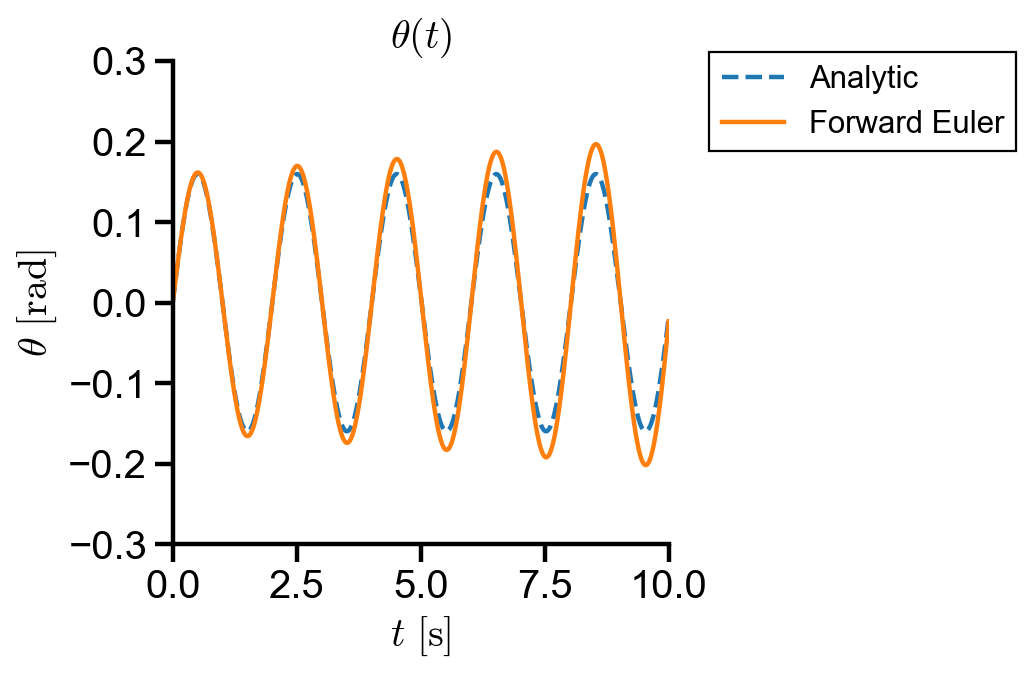

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(t, x_exact(t)[0], '--', label='Analytic')
ax.plot(t, x[0], label='Forward Euler')
ax.set_xlabel('$t \ [\mathrm{s}]$')
ax.set_ylabel('$\\theta \ [\mathrm{rad}]$')
ax.set_title('$\\theta(t)$')
ax.set_xlim(t_initial, t_final)
ax.set_ylim(-0.3, 0.3)
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05))

▲ Forward Euler has first order error and the amplitude grows over time compared to the analytic solution.

#### Backward Euler

In [10]:
# define physical constants
g = 9.8
l = 1

In [11]:
# define time array
t_initial = 0
t_final = 10
dt = 0.005
t = np.arange(t_initial, t_final+dt/2, dt)
t_len = len(t)

In [12]:
# define matrix and initial conditions
A = np.array([[0, 1], [-g/l, 0]])
x0 = np.array([0, 0.5])
x = np.zeros((2, t_len))
x[:, 0] = x0

In [13]:
P, L, U = scipy.linalg.lu(np.eye(len(A)) - dt*A)

In [14]:
# backward euler of linear system
for i in range(t_len - 1):
    y = np.linalg.solve(L, P@x[:, i])
    x[:, i+1] = np.linalg.solve(U, y)

In [15]:
# compare with analytical soln
x_exact = lambda t : np.array([0.5 * np.sqrt(l/g) *np.sin(t*np.sqrt(g/l)),
                               0.5 * np.cos(t*np.sqrt(g/l))])
x_error = np.linalg.norm(x[:, -1] - x_exact(t_final))
print(f'Error = {x_error :.2f}')

Error = 0.11


In [16]:
# assess stability
stability_matrix = np.linalg.inv(np.eye(len(A)) - dt*A)
abs_eig = abs(np.linalg.eig(stability_matrix)[0])
if max(abs_eig) > 1:
    print(f'Unstable with |lambda_max| = {max(abs_eig) :.4f}')
else:
    print(f'Stable with |lambda_max| = {max(abs_eig) :.4f}')

Stable with |lambda_max| = 0.9999


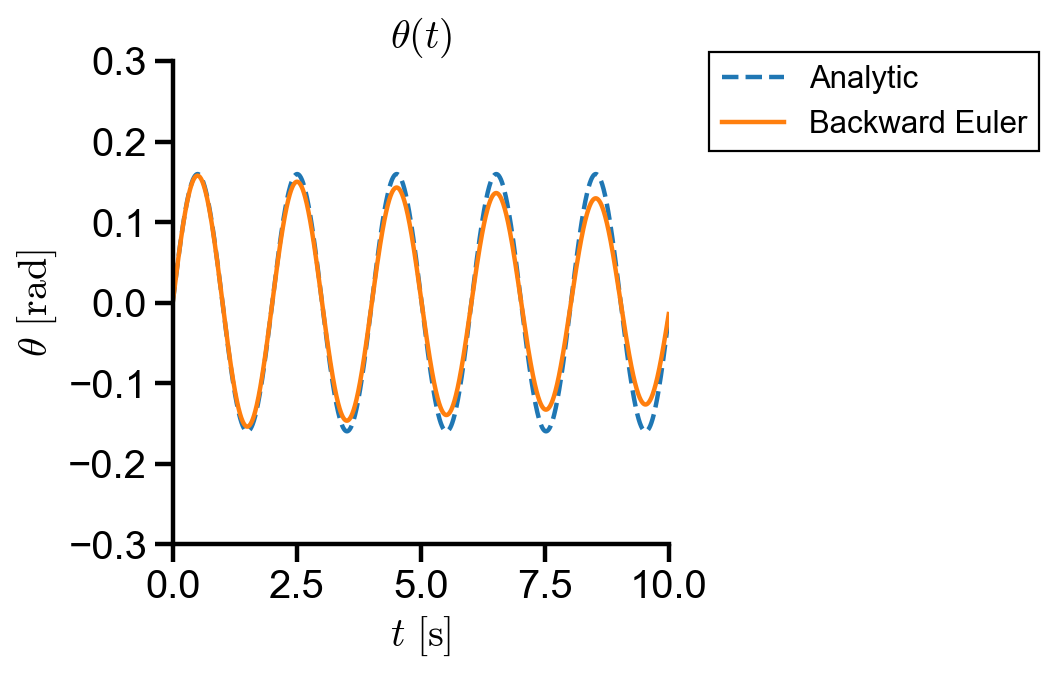

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(t, x_exact(t)[0], '--', label='Analytic')
ax.plot(t, x[0], label='Backward Euler')
ax.set_xlabel('$t \ [\mathrm{s}]$')
ax.set_ylabel('$\\theta \ [\mathrm{rad}]$')
ax.set_title('$\\theta(t)$')
ax.set_xlim(t_initial, t_final)
ax.set_ylim(-0.3, 0.3)
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05))

▲ Backward Euler has first order error and the amplitude decays over time compared to the analytic solution.

#### `scipy.integrate.solve_ivp()`

In [18]:
# define physical constants
g = 9.8
l = 1

In [19]:
# define time array
t_initial = 0
t_final = 10
dt = 0.005
t = np.arange(t_initial, t_final+dt/2, dt)
t_len = len(t)

In [20]:
# define initial conditions
x0 = np.array([0, 0.5])

In [21]:
# define ode system
dtheta_dt = lambda theta, omega : omega
domega_dt = lambda theta, omega: -g/l*theta
ode_syst = lambda t, z : np.array([dtheta_dt(*z), domega_dt(*z)])

In [22]:
# solve ode system
scipy_soln = scipy.integrate.solve_ivp(ode_syst, [t_initial, t_final], x0, t_eval=t).y

In [23]:
# compare with analytical soln
x_exact = lambda t : np.array([0.5 * np.sqrt(l/g) *np.sin(t*np.sqrt(g/l)),
                               0.5 * np.cos(t*np.sqrt(g/l))])
x_error = np.linalg.norm(scipy_soln[:, -1] - x_exact(t_final))
print(f'Error = {x_error :.4f}')

Error = 0.0015


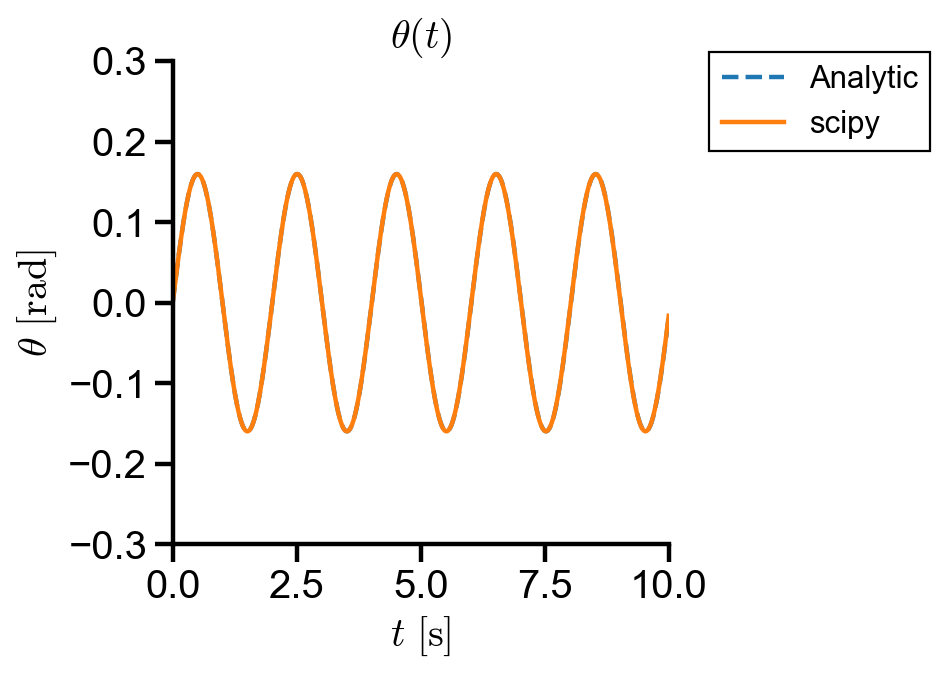

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(t, x_exact(t)[0], '--', label='Analytic')
ax.plot(t, scipy_soln[0], label='scipy')
ax.set_xlabel('$t \ [\mathrm{s}]$')
ax.set_ylabel('$\\theta \ [\mathrm{rad}]$')
ax.set_title('$\\theta(t)$')
ax.set_xlim(t_initial, t_final)
ax.set_ylim(-0.3, 0.3)
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05))

▲ The scipy implementation has fourth order error, agreeing with the analytic solution.